[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neurogym/neurogym/blob/main/docs/examples/annubes.ipynb)


## `AnnubesEnv` environment

This notebook is a simple example of how to use the `AnnubesEnv` class to create a custom environment and use it to
train a reinforcement learning agent with `stable_baselines3`.


### Installation

**Google Colab:** Uncomment and execute cell below when running this notebook on google colab.

**Local:** Follow [these instructions](https://github.com/neurogym/neurogym?tab=readme-ov-file#installation) when running
this notebook locally.


In [13]:
# ! pip install neurogym[rl]

Import everything that we are going to need below.

In [14]:
import warnings
warnings.filterwarnings("default")

from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env

import neurogym as ngym
from neurogym.envs.native.annubes import AnnubesEnv

Let's create an environment, check it works and visualize it.


In [15]:
session = {"v": 0.3, "a": 0.3, ("a", "v"): 0.4}
catch_prob = 0.5

env = AnnubesEnv(session, catch_prob)

# check the custom environment and output additional warnings (if any)
check_env(env)

# check the environment with a random agent
obs, info = env.reset()
n_steps = 10
for _ in range(n_steps):
    # random action
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated:
        obs, info = env.reset()

print(env.timing)
print("----------------")
print(env.observation_space)
print(env.observation_space.name)
print("----------------")
print(env.action_space)
print(env.action_space.name)

{'fixation': 500, 'stimulus': 1000, 'iti': 0}
----------------
Box(0.0, 1.0, (4,), float32)
{'fixation': 0, 'start': 1, 'a': 2, 'v': 3}
----------------
Discrete(2)
{'fixation': 0, 'choice': [1]}


Define a convenience function to avoid boilerplate

In [16]:
def plot_demo_env(env):
    return ngym.utils.plot_env(
        env,
        ob_traces=["fixation", "start", "a", "v"],
        num_trials=30,
        fig_kwargs={"figsize": (15, 6)},
    )

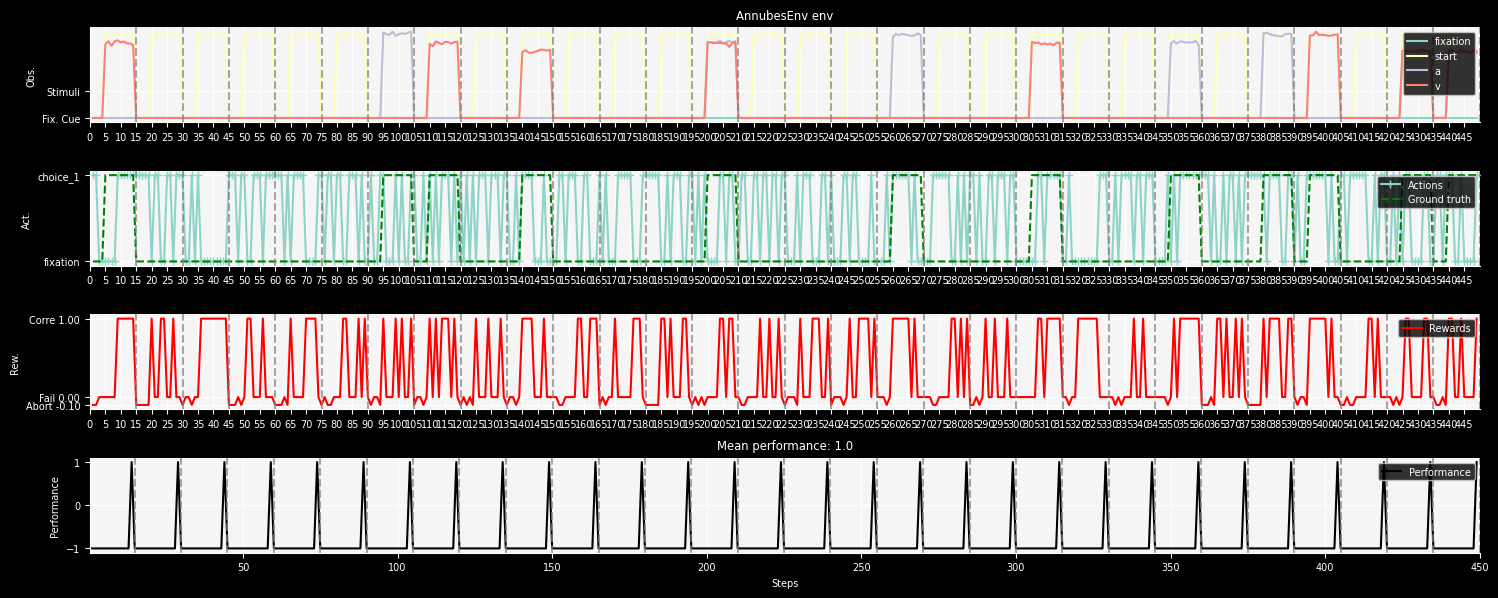

In [17]:
fig = plot_demo_env(env)

The `session` argument is a dictionary defining what stimuli should be presented during a trial and with what probabilities. A simulus can consist of a single modality (such as "auditory" or "visual", denoted as `a` and `v` below) or any combinations of the available modalities. Such combinations can be specified as tuples in the `session` dictionary with the desired probability. For instance, in the following example, modalities `v` and `a` will appear together about 40% of the time.

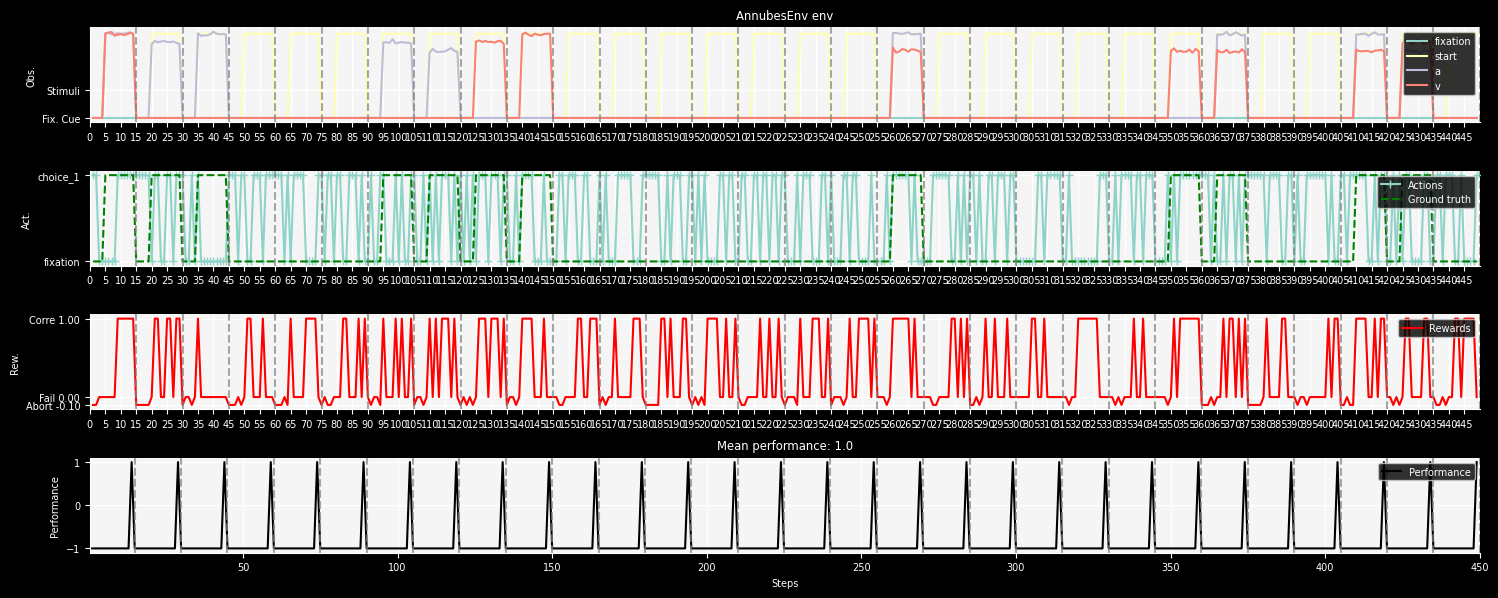

In [18]:
session = {"v": 0.3, "a": 0.3, ("a", "v"): 0.4}
catch_prob = 0.5
env = AnnubesEnv(session, catch_prob)
fig = plot_demo_env(env)

Different stimuli can even be specified without necessarily adding all the individual modalities to the `session` dictionary. The environment will automatically add missing modalities to the `session` dictionary with a probability set to 0.0. For instance, the following environment will present both `a` and `v` 50% of the non-catch trials and only `v` for the other 50%. The missing `a` modality will be added automatically to the session dictionary with a probability set to 0.0. This makes it easy, for instance, to instantiate an environment where two modalities are presented together 100% of the time but never in isolation.

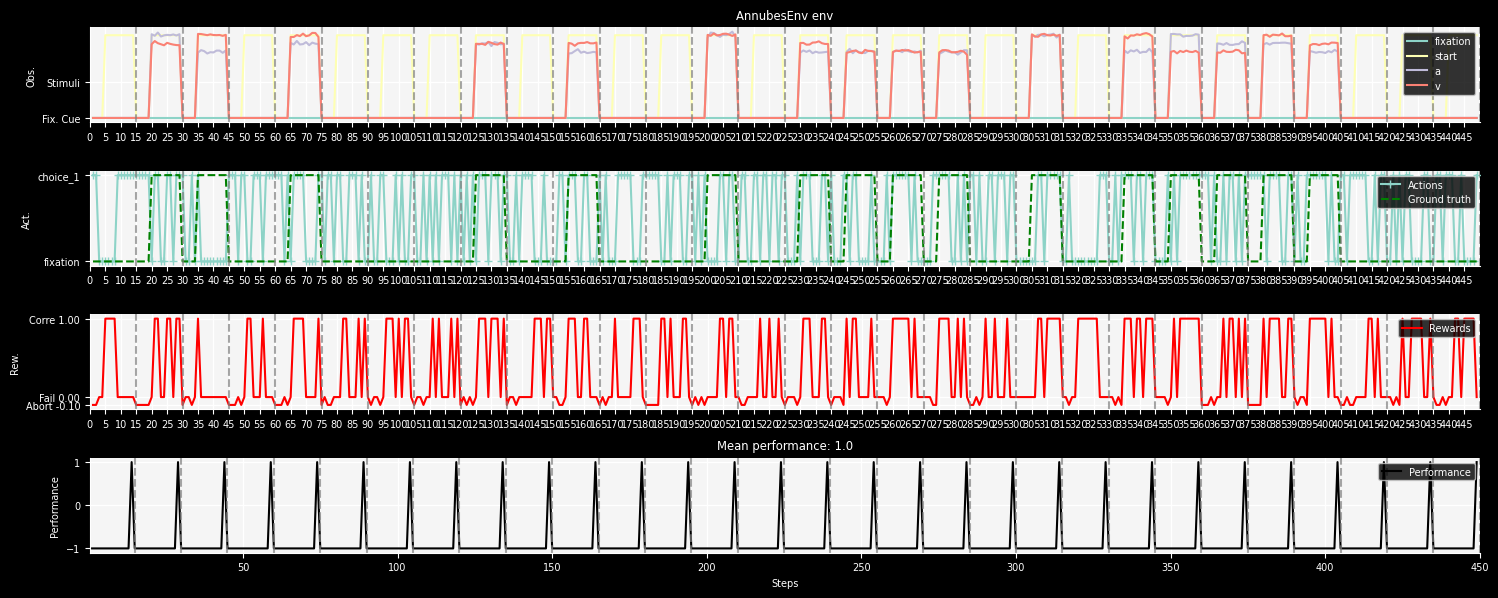

In [19]:
session = {("v", "a"): 1}
catch_prob = 0.5
env = AnnubesEnv(session, catch_prob)
fig = plot_demo_env(env)

Another point to consider is that the probabilities in the `session` dictionary don't have to add up to 1 since they are normalised upon instantiation. As a side effect, if you specify a single entry in the `session` dictionary, that entry will appear in 100% of the non-catch trials, regardless of the probability assigned (as long as it is not 0) since the probability of that entry will end up being normalised to 1. Therefore, it is possible to define the `session` with a set of relative occurrence probabilities. For instance, a session defined as `{"a": 0.25, "v": 0.75}` is the same as a session defined as `{"a": 1, "v": 3}`. 

One of the hard constraints in AnnubesEnv is that at least one of the probabilities in the `session` dictionary should be non-zero. If all probabilities sum up to `0`, an error is raised:

In [20]:
try:
    session = {"v": 0.0, "a": 0.0}
    catch_prob = 0.5
    env = AnnubesEnv(session, catch_prob)
except ValueError as e:
    print(f"Expected error raised: {e}")

Expected error raised: Please ensure that at least one modality has a non-zero probability.


As a final remark, it is also possible to restrict the number of sequential presentations of any modality by using the `max_sequential` argument. It can be an integer or a dictionary, where an integer is interpreted as a global limit applying to all modalities, whereas a dictionary gives more fine-grained control.

Note that by default the `max_sequential` constraint does *not* apply to catch trials. If you would like to set a limit on the sequential presentation of catch trials, define `max_sequential` as a dictionary and use `None` as the key representing catch trials.

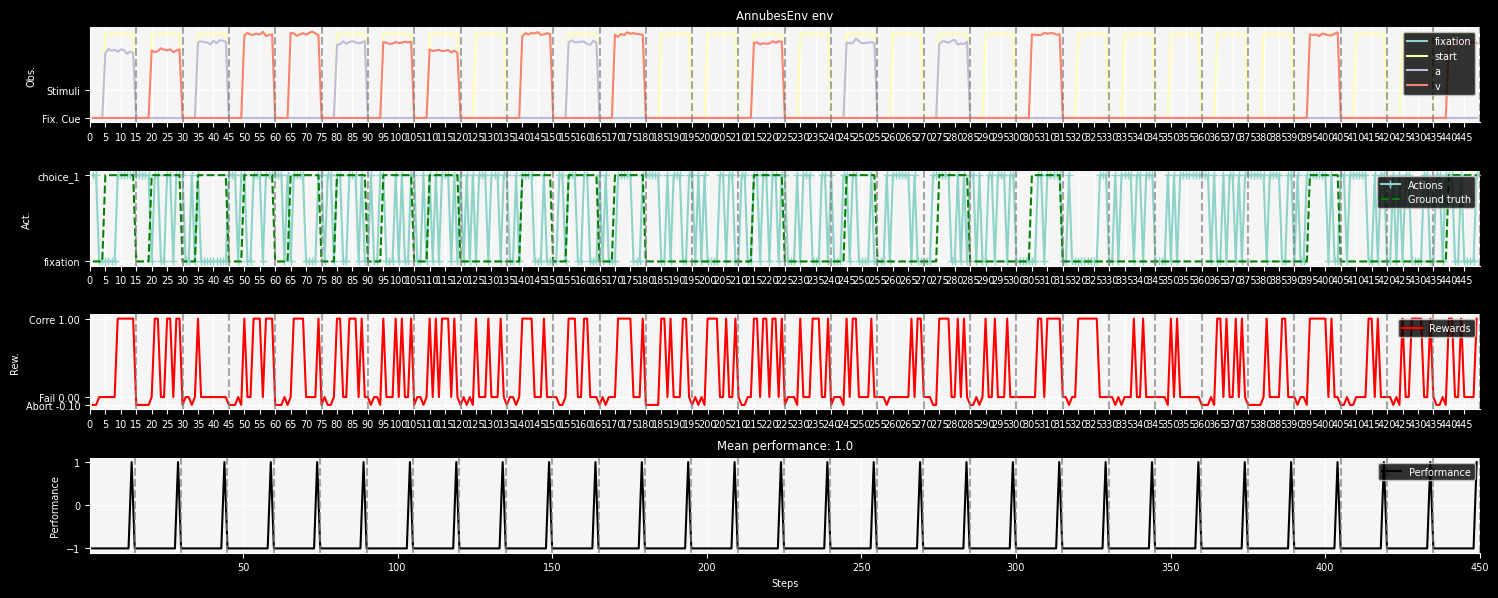

In [21]:
session = {"v": 0.5, "a": 0.5}
catch_prob = 0.5
max_sequential = 2
env = AnnubesEnv(session, catch_prob, max_sequential=max_sequential)
fig = plot_demo_env(env)

The environment also checks if the requested `max_sequential` condition is satisfiable. For instance, an error is raised if the probability of a catch trial is 0 and the probability of one or more modalities is 1 but with an imposed `max_sequential` limit:

In [22]:
try:
    # Here, 'v' appears in all entries of the session dictionary,
    # so it will occur in 100% of the non-catch trials.
    session = {"v": 0.5, ("a", "v"): 0.5}

    # Impose a global limit on sequential presentations of the same stimulus.
    max_sequential = 5

    # Ensure that there are no catch trials
    catch_prob = 0.0
    env = AnnubesEnv(session, catch_prob, max_sequential=max_sequential)
except ValueError as e:
    print(f"Expected error raised: {e}")

Expected error raised: Invalid settings: max_sequential imposes a limit on a modality that should appear in every trial.


Removing the limit eliminates the error:

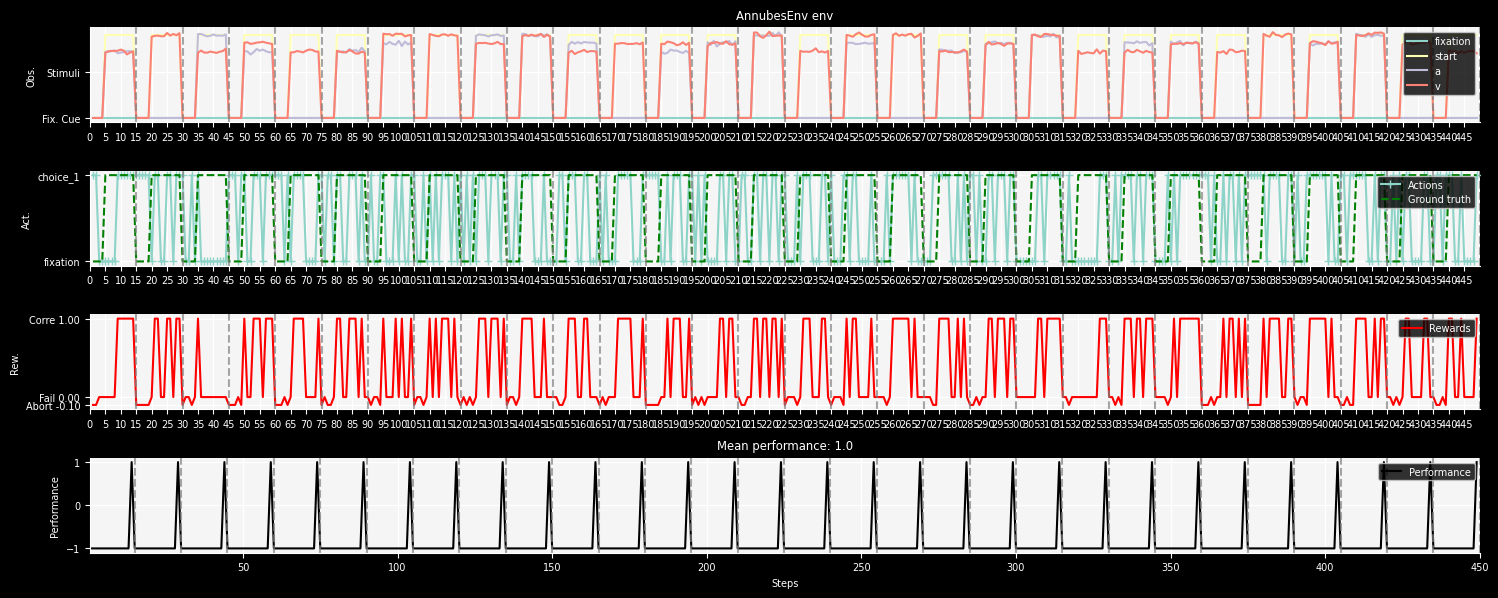

In [23]:
# Here, the probability of 'v' is in fact 1 because it appears in all entries of the session dictionary
session = {"v": 0.5, ("a", "v"): 0.5}

# Ensure that there are no catch trials
catch_prob = 0.0

# This works...
env = AnnubesEnv(session, catch_prob)
fig = plot_demo_env(env)

## Training `AnnubesEnv`

### 1. Regular training

We can train `AnnubesEnv` using one of the models defined in `stable_baselines3`, for example [`A2C`](https://stable-baselines3.readthedocs.io/en/master/modules/a2c.html).


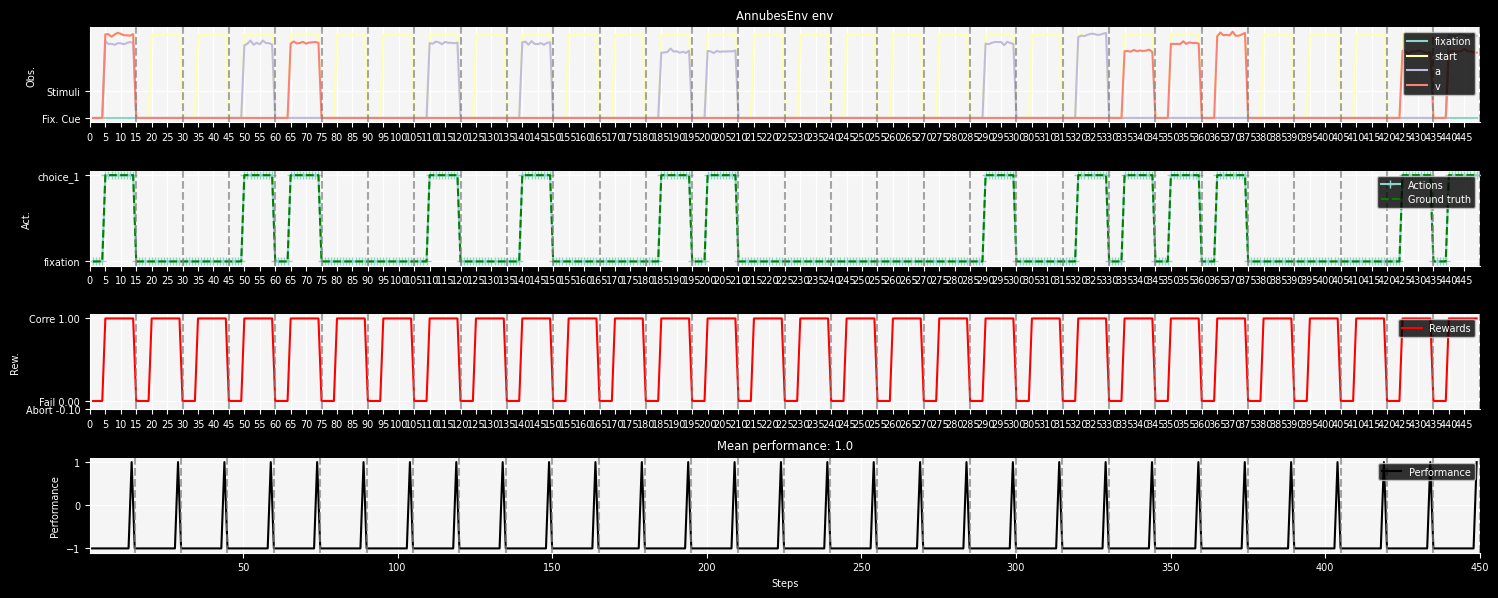

In [24]:
# Instantiate a default environment and train an agent on it.
session = {"v": 0.3, "a": 0.3, ("a", "v"): 0.4}
catch_prob = 0.5
total_timesteps = 200
log_interval = 10

env = AnnubesEnv(session, catch_prob)
env_vec = DummyVecEnv([lambda: env])
model = A2C("MlpPolicy", env_vec, verbose=0)
model.learn(total_timesteps=total_timesteps, log_interval=log_interval)
env_vec.close()

# Plot example trials with the trained agent
data = ngym.utils.plot_env(
    env, num_trials=30, ob_traces=["fixation", "start", "a", "v"], model=model, fig_kwargs={"figsize": (15,6)}
)

### 2. Sequential training

We can also train `AnnubesEnv` using a sequential training approach. This is useful when we want to train the agent in multiple stages, each with a different environment configuration. This can be useful for:

- **Curriculum learning**: Gradually increase the difficulty of the environments. Start with simpler tasks and progressively move to more complex ones, allowing the agent to build on its previous experiences.

- **Domain randomization**: Vary the environment dynamics (e.g., physics, obstacles) during training to improve the agent's robustness to changes in the environment.

- **Transfer learning**: If you have access to different agents or architectures, you can use transfer learning techniques to fine-tune the model on a new environment.

In this case it is important to include all the possible observations in each environment, even if not all of them are used. This is because the model is initialized with the first environment's observation space and it is not possible to change it later.


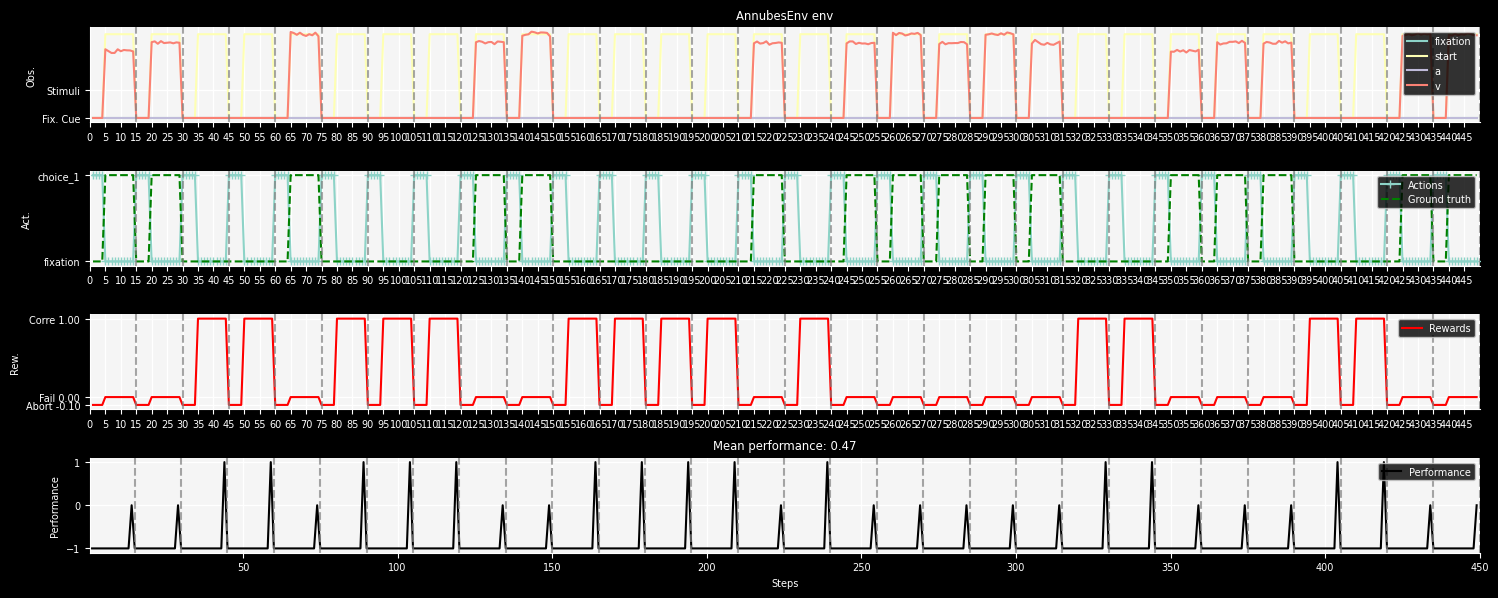

In [25]:
session = {"v": 1, "a": 0}
catch_prob = 0.5
env1 = AnnubesEnv(session, catch_prob)
env1_vec = DummyVecEnv([lambda: env1])

# Create a model and train it with the first environment
model = A2C("MlpPolicy", env1_vec, verbose=0)
model.learn(total_timesteps=total_timesteps)
env1_vec.close()

# Plot example trials with the trained agent
data = ngym.utils.plot_env(
    env1,
    num_trials=30,
    ob_traces=["fixation", "start", "a", "v"],
    model=model,
    fig_kwargs={"figsize": (15, 6)},
)

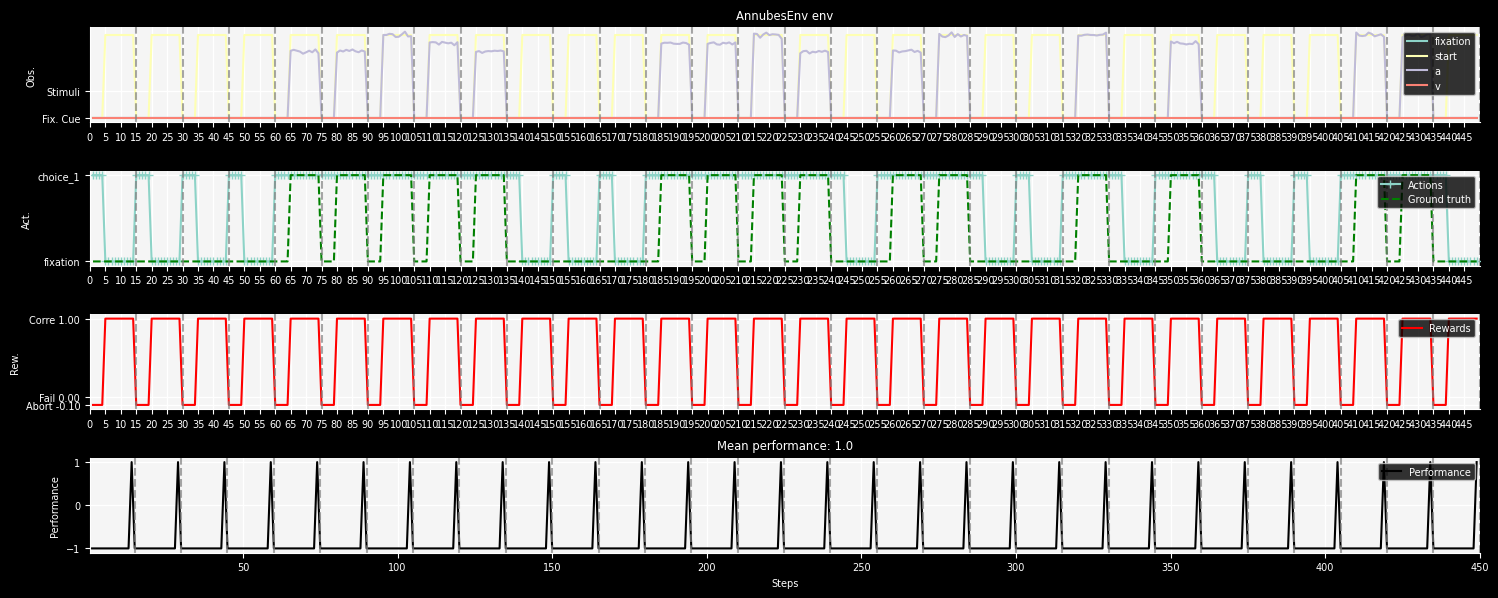

In [26]:
# Switch to the second environment and continue training
session = {"v": 0, "a": 1}
catch_prob = 0.5
env2 = AnnubesEnv(session, catch_prob)
env2_vec = DummyVecEnv([lambda: env2])

# Set the model's environment to the new environment
model.set_env(env2_vec)
model.learn(total_timesteps=total_timesteps)
env2_vec.close()

# Plot example trials with the trained agent
data = ngym.utils.plot_env(
    env2,
    num_trials=30,
    ob_traces=["fixation", "start", "a", "v"],
    model=model,
    fig_kwargs={"figsize": (15,6)},
)

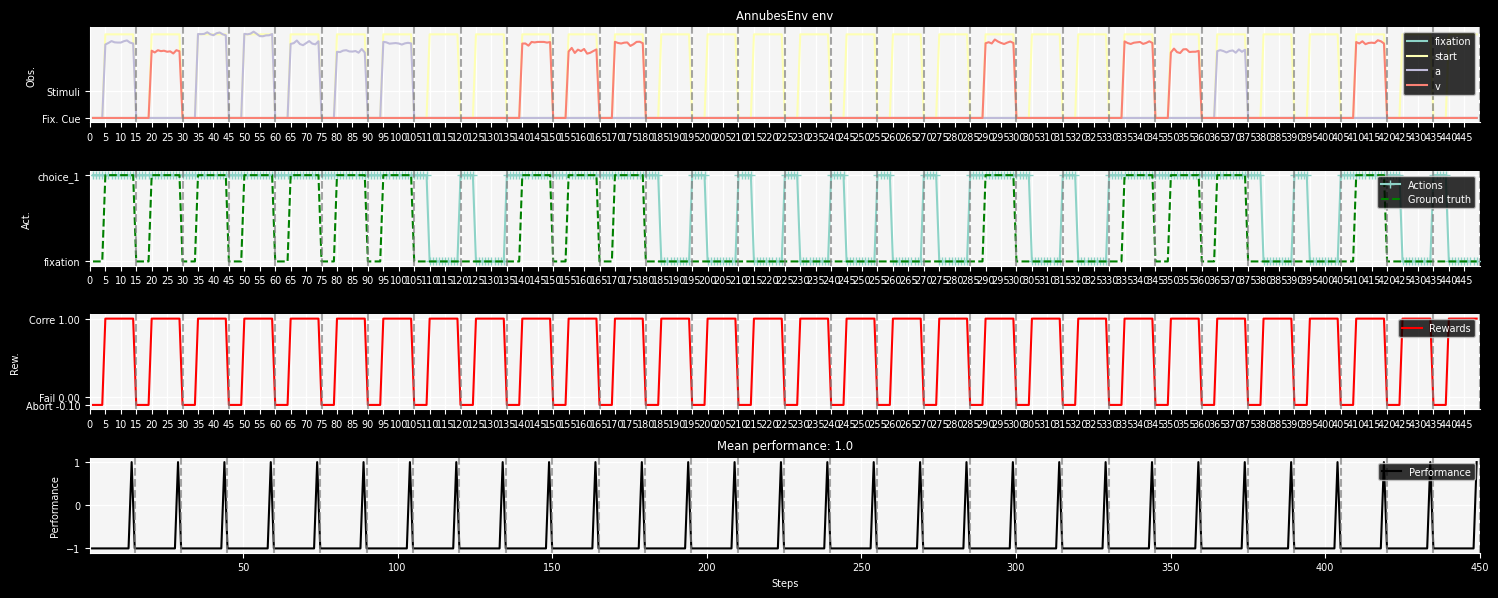

In [27]:
# Switch to the third environment and finish training
session = {"v": 0.5, "a": 0.5}
catch_prob = 0.5
env3 = AnnubesEnv(session, catch_prob)
env3_vec = DummyVecEnv([lambda: env3])

# Set the model's environment to the new environment
model.set_env(env3_vec)
model.learn(total_timesteps=total_timesteps)
env3_vec.close()

# Plot example trials with the trained agent
data = ngym.utils.plot_env(
    env3, num_trials=30, ob_traces=["fixation", "start", "a", "v"], model=model, fig_kwargs={"figsize": (15,6)},
)

In [28]:
# Save the final model after all training
model.save("final_model")